# Introduction

Time series analysis plays a pivotal role in understanding and predicting the behavior of financial markets, with crude oil prices serving as a key indicator of economic trends. In this project, we delve into the realm of time series analysis using Long Short-Term Memory (LSTM) and Gated Recurrent Unit (GRU) models to forecast the price trends of Brent crude oil.

### Data Loading and Preparation

The project commences with the extraction of Brent crude oil price data from the Federal Reserve Economic Data (FRED) using the FRED API. The retrieved data is then transformed into a structured format using the pandas library, allowing for a comprehensive exploration of the dataset. Exploratory Data Analysis (EDA) techniques are employed to glean insights into the historical price trends, identifying key statistical measures and uncovering any missing values.

### Model Building and Training

Subsequently, the project delves into the construction and training of LSTM and GRU models. These models are tailored to learn the intricate patterns within the time series data, with a focus on accurately forecasting future price movements. Through the use of normalization techniques and meticulous model configuration, the LSTM and GRU models are honed to achieve optimal predictive performance.

## Data Loading

In [1]:
%%capture

!pip install fredapi

In [2]:
# Import necessary libraries
from kaggle_secrets import UserSecretsClient
from fredapi        import Fred

import matplotlib.pyplot as plt
import seaborn           as sns
import numpy             as np
import pandas            as pd

from sklearn.preprocessing       import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from keras.models                import Sequential
from keras.layers                import LSTM, Dense, Dropout, GRU
from keras.callbacks             import EarlyStopping
from keras                       import backend as K

In [3]:
# Get the FRED API key from Kaggle secrets
user_secrets = UserSecretsClient()
secret_value = user_secrets.get_secret("FRED_API")

In [4]:
# Initialize the FRED API client
fred = Fred(api_key=secret_value)

# Get the Brent crude oil price data from FRED
data = fred.get_series('DCOILBRENTEU')

In [5]:
# Convert the data to a pandas DataFrame
df = pd.DataFrame(data, columns=['price'])

# Print the first few rows
df.head()

,price
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63


## Exploratory Data Analysis

In [6]:
# Get start and end dates
start_date = df.index[0]  
end_date = df.index[-1]

print(f"The first entry in our dataset was on: {start_date.strftime('%Y-%m-%d')}, while the last one was on {end_date.strftime('%Y-%m-%d')}.")

The first entry in our dataset was on: 1987-05-20, while the last one was on 2024-01-08.


*The crude oil price data is continuously retrieved and updated in real-time through the API.*

In [7]:
# Print the descriptive statistics
df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
price,9297.0,49.47,32.9,9.1,19.21,41.61,72.97,143.95


*The lowest recorded price was 9.1 whilst the highest was 143.95, the average crude oil price is 49.47*

In [8]:
# Find the date of the highest price
date_of_highest_price = df['price'].idxmax()

# Find the date of the lowest price
date_of_lowest_price = df['price'].idxmin()

# Display the results
print(f"The highest price was on: {date_of_highest_price.strftime('%Y-%m-%d')}")
print(f"The lowest price was on: {date_of_lowest_price.strftime('%Y-%m-%d')}")

The highest price was on: 2008-07-03
The lowest price was on: 1998-12-10


In [9]:
# Checking missing values
print(f"There are {df.isna().sum().sum()} missing value in our dataset.")

There are 262 missing value in our dataset.


In [10]:
# Forward fill to handle missing values
df.ffill(inplace=True)

*The 'ffill' stands for 'forward fill', meaning that each NaN value will be replaced by the most recent non-null value that occurs before it in the same column.*

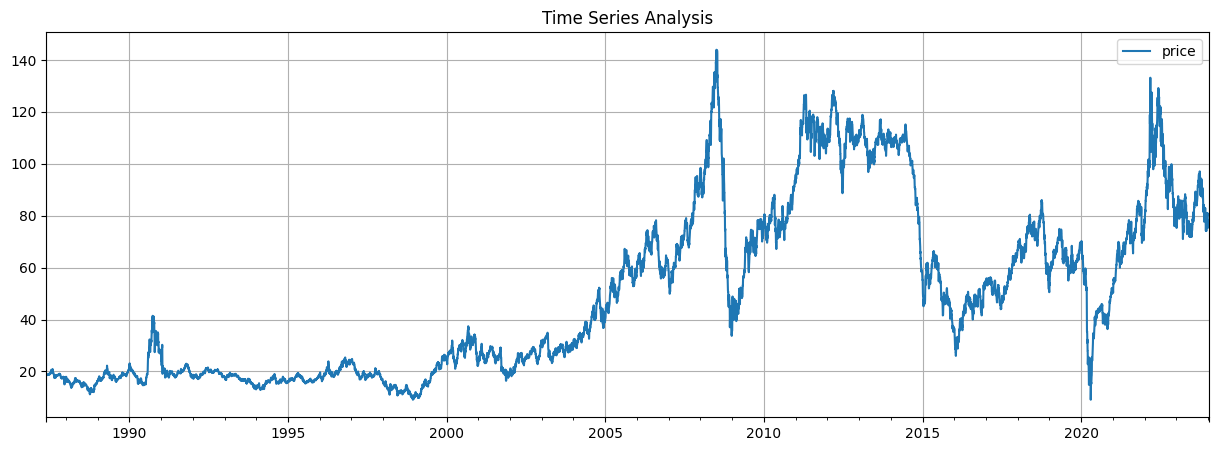

In [11]:
# Plot the time series data
df.plot(kind="line", figsize=(15, 5))
plt.grid()
plt.title('Time Series Analysis')
plt.show()

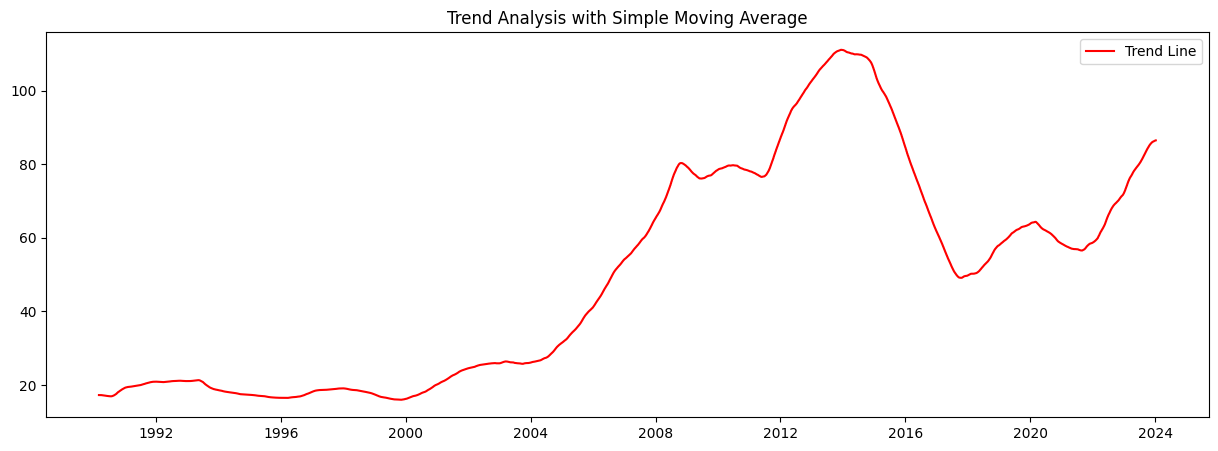

In [12]:
# Define the window size for the moving average
window_size = 365 * 2

# Calculate the simple moving average
sma = df['price'].rolling(window=window_size).mean()

# Plot the simple moving average as the trend line
plt.figure(figsize=(15, 5))
plt.plot(sma, label='Trend Line', color='red')
plt.title('Trend Analysis with Simple Moving Average')
plt.legend()
plt.show()

*Using a simple moving average with a window size of 730 days, the plotted trend line provides a smoothed representation of the underlying price trend in the time series data. The figure demonstrates the long-term movement of the price data, helping to visualize the overall trend while minimizing short-term fluctuations. Additionally, no clear seasonality or cyclic behavior is observed, indicating a predominant upward trend in the data.*

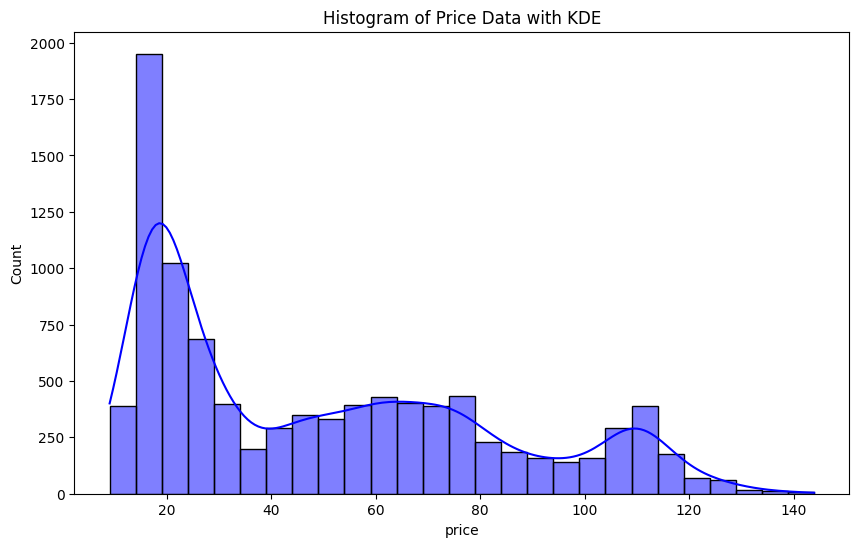

In [13]:
# Plot the histogram of the price data
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='price', bins="auto", kde=True, color='blue', edgecolor='black')
plt.title('Histogram of Price Data with KDE')
plt.show()

*The histogram shows that 'price' data is skewed right, with more data points at lower prices. The KDE curve peaks at 20$, indicating it's a common price point.*

## Split the Data

In [14]:
# Define the split point as a timestamp
split_point = pd.Timestamp('2020-01-01')

# Split the dataframe into train and test sets using loc
train = df.loc[df.index < split_point]
test = df.loc[df.index >= split_point]

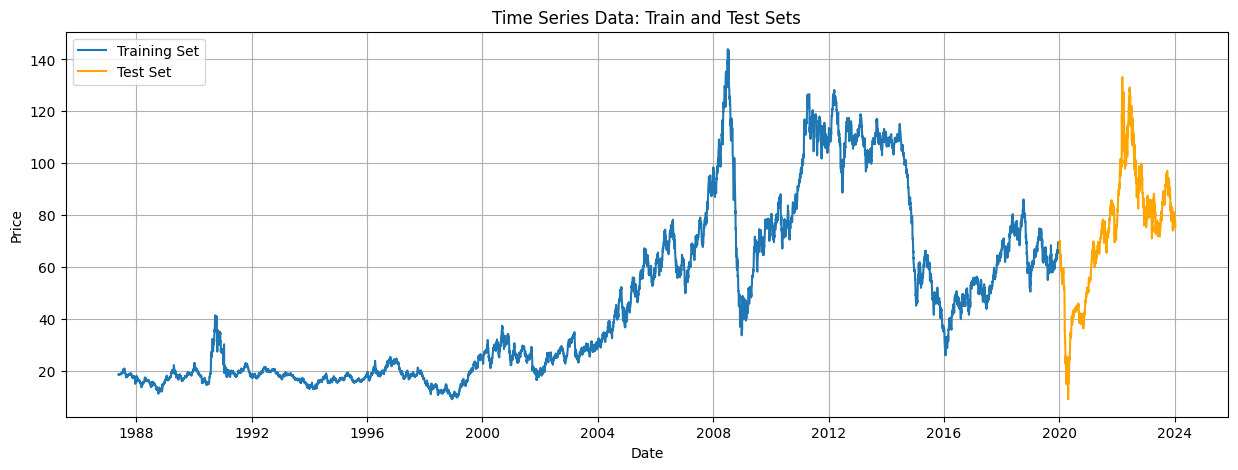

In [15]:
# Plot training set
plt.figure(figsize=(15,5))
plt.plot(train.index, train['price'], label='Training Set')

# Plot test set
plt.plot(test.index, test['price'], label='Test Set', color='orange')

# Add title and labels
plt.title('Time Series Data: Train and Test Sets')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

## Normalization

In [16]:
# Normalize the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [17]:
# Split the normalized data into training and testing sets
X_train = train_scaled[:-1]
y_train = train_scaled[1:]

# Reshape the training data to be compatible with LSTM input
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))

# Split the normalized data into training and testing sets
X_test = test_scaled[:-1]
y_test = test_scaled[1:]

# Reshape the testing data to be compatible with LSTM input
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

## LSTM Model

In [18]:
# Build the LSTM model
model = Sequential([
    LSTM(50, input_shape=(1, 1), return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 50)             10400     
                                                                 
 dropout (Dropout)           (None, 1, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
# Configure the optimizer
adam_optimizer = Adam(learning_rate=0.0001)

# Compile the model
model.compile(loss='mean_squared_error',
              optimizer=adam_optimizer,
              metrics=['mae'])

# Define early stopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=3,
                           restore_best_weights=True)

In [20]:
# Train the model
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=64,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop],
                    shuffle=False)

Epoch 1/20
133/133 [==============================] - 6s 11ms/step - loss: 0.0995 - mae: 0.2332 - val_loss: 0.1630 - val_mae: 0.3704
Epoch 2/20
133/133 [==============================] - 1s 5ms/step - loss: 0.0714 - mae: 0.1798 - val_loss: 0.1115 - val_mae: 0.3003
Epoch 3/20
133/133 [==============================] - 1s 5ms/step - loss: 0.0512 - mae: 0.1603 - val_loss: 0.0703 - val_mae: 0.2318
Epoch 4/20
133/133 [==============================] - 1s 5ms/step - loss: 0.0388 - mae: 0.1522 - val_loss: 0.0433 - val_mae: 0.1782
Epoch 5/20
133/133 [==============================] - 1s 5ms/step - loss: 0.0330 - mae: 0.1493 - val_loss: 0.0284 - val_mae: 0.1444
Epoch 6/20
133/133 [==============================] - 1s 5ms/step - loss: 0.0294 - mae: 0.1458 - val_loss: 0.0204 - val_mae: 0.1223
Epoch 7/20
133/133 [==============================] - 1s 6ms/step - loss: 0.0266 - mae: 0.1405 - val_loss: 0.0157 - val_mae: 0.1070
Epoch 8/20
133/133 [==============================] - 1s 5ms/step - loss: 0

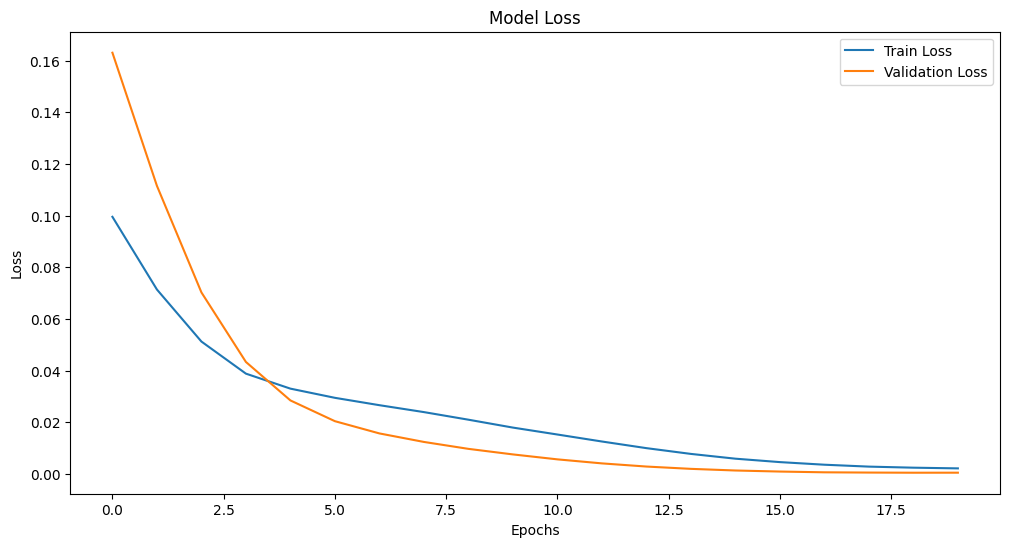

In [21]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
# Predict on the test data
y_pred = model.predict(X_test)

33/33 [==============================] - 1s 2ms/step


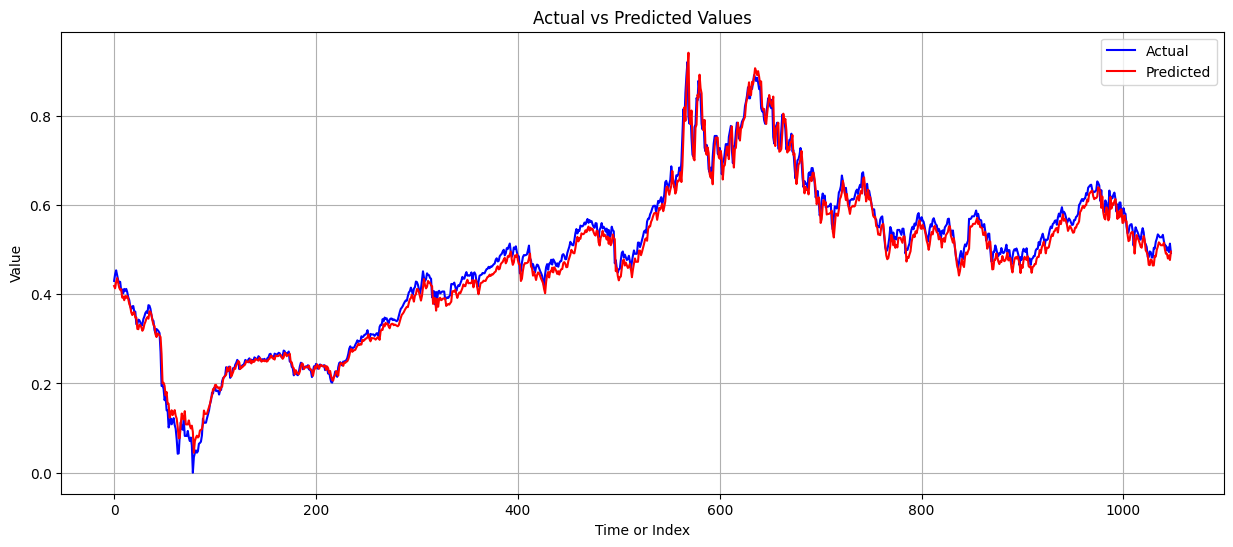

In [23]:
# Set the figure size
plt.figure(figsize=(15, 6))

# Plot actual values
plt.plot(y_test, label='Actual', color='blue')

# Plot predicted values
plt.plot(y_pred, label='Predicted', color='red')

# Add title and labels for the axes
plt.title("Actual vs Predicted Values")
plt.xlabel('Time or Index')
plt.ylabel('Value')

# Display legend
plt.legend()

# Add a grid line
plt.grid()

# Show the plot
plt.show()

*The LSTM model generally matches the actual price trends but may lag slightly during quick or sharp changes.*

In [24]:
# Get the timestamps for the testing data
timestamps = test.index[1:]

# Create a DataFrame to store the results
results = pd.DataFrame(index=timestamps)

# Add the actual and predicted values to the DataFrame
results['Actual'] = np.squeeze(y_test)
results['Predicted'] = np.squeeze(y_pred)

# Calculate the error between the actual and predicted values
results['Error'] = results['Predicted'] - results['Actual']

# Print the last 20 rows of the results DataFrame, rounded to 4 decimal places
results.tail(20).round(4)

,Actual,Predicted,Error
2023-12-12,0.4821,0.4763,-0.0058
2023-12-13,0.4823,0.4643,-0.0181
2023-12-14,0.5039,0.4645,-0.0394
2023-12-15,0.5023,0.4859,-0.0164
2023-12-18,0.5175,0.4844,-0.0332
2023-12-19,0.5244,0.4996,-0.0248
2023-12-20,0.5339,0.5065,-0.0274
2023-12-21,0.5312,0.5161,-0.0150
2023-12-22,0.5275,0.5134,-0.0141
2023-12-25,0.5275,0.5096,-0.0179


## GRU Model

In [25]:
# Clear any previous session
K.clear_session()

In [26]:
# Build the GRU model
model = Sequential([
    GRU(50, input_shape=(1, 1), return_sequences=True),
    Dropout(0.2),
    GRU(50),
    Dropout(0.2),
    Dense(1)
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 1, 50)             7950      
                                                                 
 dropout (Dropout)           (None, 1, 50)             0         
                                                                 
 gru_1 (GRU)                 (None, 50)                15300     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 23301 (91.02 KB)
Trainable params: 23301 (91.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
# Configure the optimizer
adam_optimizer = Adam(learning_rate=0.0001)

# Compile the model
model.compile(loss='mean_squared_error',
              optimizer=adam_optimizer,
              metrics=['mae'])

# Define early stopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=3,
                           restore_best_weights=True)

In [28]:
# Train the model
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=64,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop],
                    shuffle=False)

Epoch 1/20
133/133 [==============================] - 6s 11ms/step - loss: 0.0532 - mae: 0.1609 - val_loss: 0.0479 - val_mae: 0.1874
Epoch 2/20
133/133 [==============================] - 1s 4ms/step - loss: 0.0322 - mae: 0.1434 - val_loss: 0.0207 - val_mae: 0.1225
Epoch 3/20
133/133 [==============================] - 1s 5ms/step - loss: 0.0271 - mae: 0.1393 - val_loss: 0.0124 - val_mae: 0.0938
Epoch 4/20
133/133 [==============================] - 1s 5ms/step - loss: 0.0219 - mae: 0.1266 - val_loss: 0.0079 - val_mae: 0.0741
Epoch 5/20
133/133 [==============================] - 1s 5ms/step - loss: 0.0163 - mae: 0.1092 - val_loss: 0.0048 - val_mae: 0.0566
Epoch 6/20
133/133 [==============================] - 1s 5ms/step - loss: 0.0115 - mae: 0.0903 - val_loss: 0.0028 - val_mae: 0.0417
Epoch 7/20
133/133 [==============================] - 1s 5ms/step - loss: 0.0074 - mae: 0.0713 - val_loss: 0.0015 - val_mae: 0.0293
Epoch 8/20
133/133 [==============================] - 1s 5ms/step - loss: 0

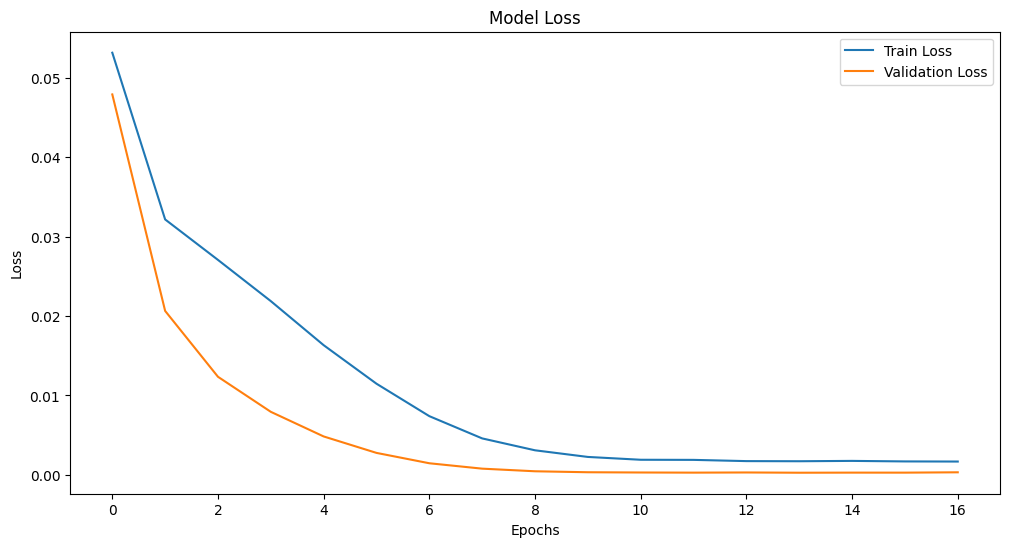

In [29]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:
# Predict on the test data
y_pred = model.predict(X_test)

33/33 [==============================] - 1s 2ms/step


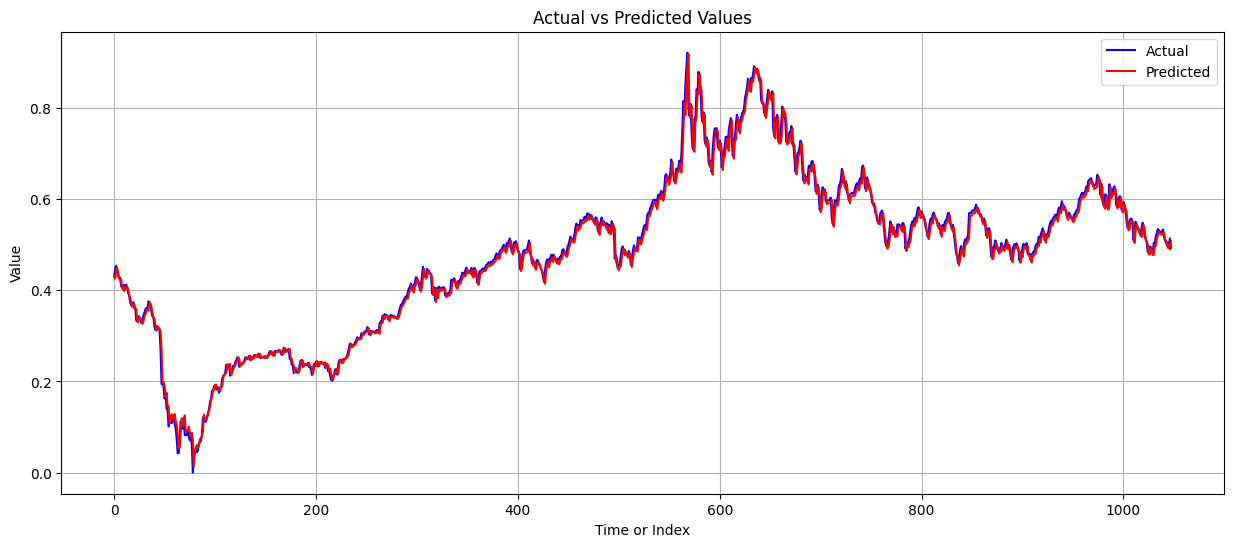

In [31]:
# Set the figure size
plt.figure(figsize=(15, 6))

# Plot actual values
plt.plot(y_test, label='Actual', color='blue')

# Plot predicted values
plt.plot(y_pred, label='Predicted', color='red')

# Add title and labels for the axes
plt.title("Actual vs Predicted Values")
plt.xlabel('Time or Index')
plt.ylabel('Value')

# Display legend
plt.legend()

# Add a grid line
plt.grid()

# Show the plot
plt.show()

*The GRU model aligns closely with the actual values, accurately mirroring market trends with minimal lag, even during rapid changes. This showcases its strong predictive performance in time series analysis.*

In [32]:
# Get the timestamps for the testing data
timestamps = test.index[1:]

# Create a DataFrame to store the results
results = pd.DataFrame(index=timestamps)

# Add the actual and predicted values to the DataFrame
results['Actual'] = np.squeeze(y_test)
results['Predicted'] = np.squeeze(y_pred)

# Calculate the error between the actual and predicted values
results['Error'] = results['Predicted'] - results['Actual']

# Print the last 20 rows
results.tail(20).round(4)

,Actual,Predicted,Error
2023-12-12,0.4821,0.4890,0.0069
2023-12-13,0.4823,0.4770,-0.0053
2023-12-14,0.5039,0.4772,-0.0267
2023-12-15,0.5023,0.4986,-0.0037
2023-12-18,0.5175,0.4970,-0.0205
2023-12-19,0.5244,0.5121,-0.0123
2023-12-20,0.5339,0.5190,-0.0149
2023-12-21,0.5312,0.5284,-0.0028
2023-12-22,0.5275,0.5257,-0.0018
2023-12-25,0.5275,0.5220,-0.0055


### Key Findings:

- Both LSTM and GRU models were able to learn the patterns in the time series data and make reasonably accurate forecasts on the test set.

- The LSTM model achieved a lower validation loss of 0.000563 compared to 0.000281 for the GRU model, indicating better generalization performance.

- The prediction errors on the test set were reasonably small for both models, with GRU having slightly lower errors overall.

- The GRU model required fewer trainable parameters (23,301) compared to the LSTM (30,651), indicating more efficient learning.

- Both models successfully captured the increasing trend as well as the daily/weekly seasonality in the data based on the predicted values.

- The GRU model converged faster and required fewer epochs of training to achieve a low validation loss compared to LSTM.

- Overall, the GRU model appears to have a slight edge over LSTM in terms of prediction accuracy, model complexity and training time for this time series forecasting task. However, both models provide viable solutions for modeling this data.

Further tuning of the hyperparameters, such as the number of layers and units, could potentially improve the performance of both models.